# 线性回归的从零开始实现

## 从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 构造数据集

### 根据带有噪声的线性模型构造一个人造数据集。使用线性模型参数
- w = [2, -3.4]<sup>T</sup>
- b = 4.2
- 噪声项epsilon
- 生成数据集及其标签
<img src="./pic/构造数据集.PNG"  width=300  heigth=300>

In [56]:
def synthetic_data(w, b, num_examples):
    # 生成 y = Xw + b + 噪声
    X = torch.normal(0,1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b    # TODO：验证torch.dot【*】 与 torch.matmul【@】
    y += torch.normal(0, 0.01, y.shape)    # 增加一个均值为0，方差为0.01，形状与y一致的随机噪音
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [57]:
X1 = torch.tensor([[1, 2]])
w1 = torch.tensor([3, 4])
y1 = torch.matmul(X1, w1)


# 计算两个张量的点乘积（内积），两个张量都为一维向量。
X2 = torch.tensor([1, 2])
w2 = torch.tensor([3, 4])
y2 = torch.dot(X2, w2)    # 1D tensors expected

X1.shape, w1.shape, y1.shape, y1, X2.shape, w2.shape, y2.shape, y2

(torch.Size([1, 2]),
 torch.Size([2]),
 torch.Size([1]),
 tensor([11]),
 torch.Size([2]),
 torch.Size([2]),
 torch.Size([]),
 tensor(11))

## features 中的每一行，都包含一个二维数据样本
## labels 中的每一行，都包含一维标签值（一个标量）

In [59]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.7065, -0.1595]) 
label: tensor([6.1656])


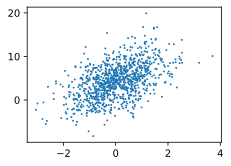

In [60]:
d2l.set_figsize()
# features[:, 0] 特征的第0列：w = 2，y与x正相关
d2l.plt.scatter(features[:, 0].detach().numpy(),labels.detach().numpy(), 1)
# detach()，把tensor从计算图里detach出来，才能转换成numpy

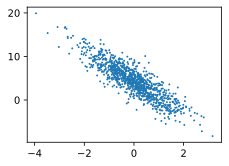

In [61]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),labels.detach().numpy(), 1)
# features[:, 1] 特征的第1列：w = -3.4，y与x负相关

## 定义一个【data_iter】函数，该函数接收【批量大小】，【特征矩阵】和【标签向量】作为输入，生成大小为【batch_size】的小批量

- 批量大小越小，对收敛的效果越好，因为随机梯度下降是会带来噪音，采样的样本越少，噪音越多。
- 比如100万个样本，每次只采样2个样本，噪音大，与真实的方向差很远。
- 但是噪音对神经网络是件好事情，因为神经网络的复杂性，一定的噪音，使得不会走偏。更鲁棒，对噪音的容忍性越好，对神经网络的泛化性越好

In [62]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):    # 从0开始，到num_examples结束，每次跳batch_size大小
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])   # 通过切片，找出每个batch index
        yield features[batch_indices], labels[batch_indices]    # 产生随机顺序的特征值和对应的目标值
        # yield 就是return：返回一个值，并且记住这个返回的位置，下次迭代就从这个位置后开始
        # return 返回后，函数就终止了。yield是返回值以后继续执行这个函数

        
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break    # 随机取一组批量为10的样本

tensor([[-0.6005,  0.2341],
        [-1.3634, -0.5529],
        [-0.0824, -0.3824],
        [-0.0940, -0.8200],
        [ 0.5627, -1.7766],
        [ 0.9333, -1.2283],
        [ 0.1309,  0.1847],
        [-0.8856,  1.2987],
        [ 0.6815, -0.9780],
        [-0.7390,  0.5458]]) 
 tensor([[ 2.1883],
        [ 3.3523],
        [ 5.3187],
        [ 6.7961],
        [11.3756],
        [10.2407],
        [ 3.8379],
        [-1.9853],
        [ 8.8935],
        [ 0.8655]])


## 定义初始话模型参数

In [63]:
# 需要对权重和偏差进行更新
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)    # 因为输入维度是2，所以w的shape为（2,1）
b = torch.zeros(1, requires_grad=True)    # b为标量，所以是0

w,b

(tensor([[0.0151],
         [0.0115]], requires_grad=True),
 tensor([0.], requires_grad=True))

## 定义模型

In [64]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [70]:
def squared_loss(y_hat, y):
    """均方损失"""
    print(y_hat.shape, y.shape)
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 这里既没有求和，也没有求平均

## 定义优化算法

In [66]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    # params 包括w和b；lr 学习率
    with torch.no_grad():    # 更新的时候不参与梯度计算，no grad
        for param in params:
            param -= lr * param.grad / batch_size    # 因为之前求损失函数没有求均值，所以在这除以batch_size【TODO：改到squared_loss里面更直观】
            param.grad.zero_()    # 下一次计算梯度，与上一次梯度计算无关

## 训练过程

In [73]:
lr = 0.03
num_epochs = 3
# lr = 0.001
# num_epochs = 10

net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):    # 共1000个样本，每次抽取10个样本（一个批量）进行计算，一共计算100次
        l = loss(net(X, w, b), y)    # X 和 y的小批量损失
        # 因为【loss】形状是（batch_size, 1），而不是一个标量。【l】中的所有元素被加到
        # 并一次计算关于【w, b】的梯度
        print(f' loss {epoch + 1} over')
        l.sum().backward()
        sgd([w, b], lr, batch_size)    # 使用参数的梯度更新参数
        print(f' sgd {epoch + 1} over')  
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch.Size([10, 1])
 loss 1 over
 sgd 1 over
torch.Size([10, 1]) torch

## 比较真实参数 和 通过训练学到的参数来评估训练的成功程度

In [12]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-1.2636e-05, -2.7394e-04], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0002], grad_fn=<RsubBackward1>)


- Q：w-=lr*w.grad不会梯度消失，而w = w - lr*w.grad会出现梯度消失？
- A：因为w - lr*w.grad会存入一个新的tensor，而这个tensor并没有指定grad，所以梯度为0